# Visualizations of Parallax and Proper Motions

Produce GIF animations demonstrating parallaxes and proper motions derived for nearby stars measured
using Gaia and the Gaia DR3 database.

Original Author: Erik Tollerud

Inspired by James Davenport via https://twitter.com/jradavenport/status/976205932274245632.

Requires Python 3.9, `astropy` (tested on v5.1), `astroquery` (v0.4.6), and `matplotlib` (v3.7.1).

This is a shortened version of Erik's longer demo, cutting out some of the bits about what we can get
from database queries, and the visualizations of including radial velocities, leaving us with the
animations shown in the Astronomy 2292 class.

See Erik Tollerud's github repository with the original notebook [gist.github.com/eteq](https://gist.github.com/eteq) for the full demo.

In [86]:
import numpy as np

import time

# astropy modules

import astropy.units as u
from astropy.io import votable
from astropy.coordinates import SkyCoord, CartesianRepresentation, SphericalRepresentation, matrix_utilities
from astropy.table import Table

# matplotlib for plotting and visualization

from matplotlib import cm, colors, pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# astroquery for the Gaia database queries

from astroquery import gaia
from astroquery.gaia import Gaia as g
from astroquery.utils.tap import TapPlus

# suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)
warnings.filterwarnings('ignore',category=RuntimeWarning, append=True)

# some basic setup

g.ROW_LIMIT = -1

using_ari = False

# uncomment these lines to switch to using ARI
#
# orig_gaia = g
# arigaia = gaia.GaiaClass(TapPlus('http://gaia.ari.uni-heidelberg.de/tap'))
# g = arigaia
# using_ari = True

# If using the ARI implementation, this fixes an issue with column identifications
# (don't use ARI if you don't have to).

def fix_ari_query(job):
    from urllib.request import urlopen
    from xml import etree

    remtree = etree.ElementTree.parse(urlopen(job.get_remote_location()))

    res_elem = remtree.find('*/{http://www.ivoa.net/xml/UWS/v1.0}result')
    res_url = res_elem.attrib['{http://www.w3.org/1999/xlink}href']
    res_url

    vtab = votable.parse(res_url)

    for fi in vtab.iter_fields_and_params():
        if not isinstance(fi, votable.tree.Field):
            continue #params
        fi.ID = fi.name
    return vtab.get_first_table().to_table()

## Gaia DR3 Query

Execute a query to retrieve Gaia DR3 stars brighter than G=12 within 100 pc (Gaia parallax greater than 10mas).

### This is the slow step!

Depending on your internet connection and server load, this can take ~1 minute to complete.  Just be
patient, it will run or if the server is too busy it may time out.

In [100]:
pclim = 100*u.pc
pxlim = pclim.to(u.marcsec, u.parallax())

qry=f"""
SELECT *
FROM gaiadr3.gaia_source
WHERE parallax >= {pxlim.value} AND phot_g_mean_mag <= 12
"""

print('Launching Gaia DR3 query...')

t0 = time.time()
job = g.launch_job_async(qry)
tab = job.get_results()
dt = time.time() - t0

print(f'Retrieved {len(tab)} stars (query took {dt:.1f} seconds)')

# only need to do the fix described above if the ARI mirror is used

if using_ari:
    tab = fix_ari_query(job)

Launching Gaia DR3 query...
INFO: Query finished. [astroquery.utils.tap.core]
Retrieved 60235 stars (query took 62.4 seconds)


## Condition data

### Reformat to facilitate coordinate transforms

Reformat the data table retreved from our the Gaia DR3 database query into an Astropy `SkyCoord` object
so we can perform the complicated geometric transformations needed for the visualizations.

`SkyCoord` is very powerful (if slow) and can perform the transformations and units converions with
just a few lines of code.  Be aware this is not standard Python, but using `astropy` is becoming standard
practice within astronomy.  This demo touches on the surface of what is available with `astropy`.

In [88]:
mag = np.array(tab['phot_g_mean_mag'])
scnow = SkyCoord(tab['ra'], tab['dec'], 
                 distance=(np.array(tab['parallax'])*u.mas).to(u.pc, u.parallax()))

### Restrict the data used for the visualizations

The query retrieved >60k stars, we need to reduce the number of stars we show to make the plots less
cluttered.  We do this by imposing the following cuts:
 * stars brighter than G=8mag
 * stars closer than 50pc
 
This could have been done in the query above to reduce the query overhead, but sometimes it is useful to have
more data than you need. Try playing with the limits and see how it changes the plot to see why we chose
these parameters

In [89]:
magLimit = 8
distLimit = 50*u.pc

msk = (mag < magLimit) & (scnow.distance < distLimit)

mag = mag[msk]
scnow = scnow[msk]
print(f'There are {np.sum(msk)} stars brighter than G={magLimit:.1f} and d<{distLimit:.1f}')

There are 3147 stars brighter than G=8.0 and d<50.0 pc


### Test: Physical Space rendering

This is a quick look at the data in *physical* space before we try to project it into a
more "as you'd see it" form by ploting the stars in cartesian coordinates. 

Here their G magnitude coded by point size (brighter stars are larger) and their distances are
coded by color (yellow is closest shading to deeper blue as they get farther away).

You can reverse the point representation by commenting out the relevant code (and commenting out
the other).

This test plot will show you how cluttered plotting a few thousand stars can be before we commit
to rendering the animations.

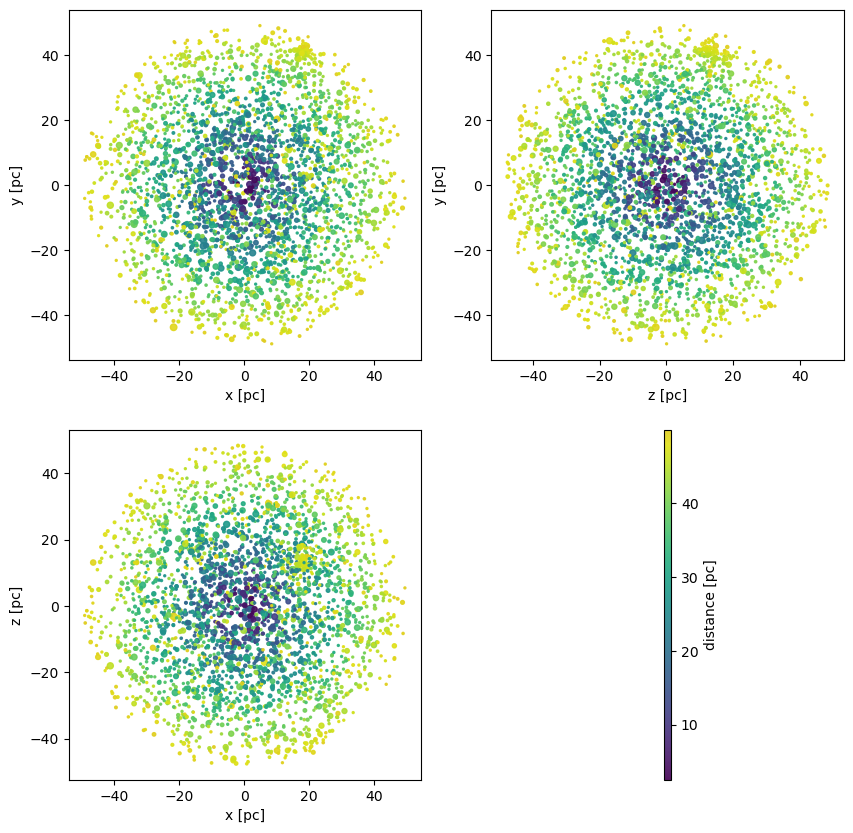

In [90]:
# Make a special version of the viridis colormap that goes to a darker yellow at the end. 
# This makes it easier to see small points on a white background.

newvhsv = colors.rgb_to_hsv(cm.viridis.colors)
newvhsv[:,-1] = np.minimum(newvhsv[:,-1], .88)
darker_vidiris = colors.ListedColormap(colors.hsv_to_rgb(newvhsv))

# code brightness as size, distance as color

def mag_to_size(mag):
    unity_rescaled_mag = (np.max(mag) - mag)/np.ptp(mag)
    return 20*unity_rescaled_mag**2+2

scatkwargs = dict(s=mag_to_size(mag), alpha=.9, c=scnow.distance, cmap=darker_vidiris)
colorUnits = 'distance [pc]'

# code distance as size, brightness as color
#
#def distance_to_size(distance):
#    unity_distance = distance/np.max(distance)
#    return 20*(1-unity_distance)+4
#
#scatkwargs = dict(s=distance_to_size(scnow.distance), alpha=.9, c=mag, cmap=darker_vidiris.reversed())
#colorUnits = 'apparent G [mag]'

# Make the figure, 3 panels projecting onto 3 orthogonal planes (x-y, y-z, x-z).  The 4th panel
# has the color bar showing the color rendering.

fig = plt.figure(figsize=(10, 10))

ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0))
axs = [ax1, ax2, ax3]

x, y, z = scnow.cartesian.xyz

ax1.scatter(x, y, **scatkwargs)
ax1.set_xlabel('x')
ax1.set_ylabel('y')

ax2.scatter(z, y, **scatkwargs)
ax2.set_xlabel('z')
ax2.set_ylabel('y')

scres = ax3.scatter(x, z, **scatkwargs)
ax3.set_xlabel('x')
ax3.set_ylabel('z')

ax4 = plt.subplot2grid((2, 2), (1, 1))
ax4.set_aspect(1)
plt.colorbar(scres, cax=ax4).set_label(colorUnits)

for ax in axs:
    ax.set_xlabel(ax.get_xlabel() + ' [{}]'.format(scnow.distance.unit))
    ax.set_ylabel(ax.get_ylabel() + ' [{}]'.format(scnow.distance.unit))

## Annual parallax visualizations

We mock up a fake "Earth orbit" by offsetting the stars in the x-y plane of the Ecliptic coordinate system (i.e., in the plane of the Earth's orbit around the sun). If we made an animation using true orbit dimensions
the parallaxes would be too small to see unless we zoomed in on a single star.

To make the annual parallax motions visible we exaggerate it enormously by making our visualization from
the perspective of a pseudo-Earth that orbits 1 light-year instead of 1 AU from the Sun.  

Note that we leave as an settable parameter the function that sends the Cartesian representation to the
spherical coordinates that are actually being visualized (by looking up along the z-axis).  We'll use that to 
acheieve various other views below.

Change the value of `amplitude` below to change the exaggerated "Earth" vantage point.  Mind the units!

In [91]:
amplitude = 1*u.lightyear

repr0 = scnow.barycentrictrueecliptic.cartesian

def animfunc(phase, eclcart_to_spherical, centerstr, ylims, ax):
    drepr = CartesianRepresentation([np.cos(phase),np.sin(phase),0]*amplitude)
    rep = repr0 + drepr
    srep = eclcart_to_spherical(rep)
    
    ax.cla()
    ax.set_title(f'Center={centerstr}, Earth semimajor axis={amplitude}')
    ax.scatter(srep.lon.rad, 90-srep.lat.deg, **scatkwargs)
    ax.set_ylim(*ylims)
    ax.set_yticks(np.linspace(*ax.get_ylim(), 5)[1:])
    ax.set_yticklabels(['{}'.format(int(90-yl)) for yl in ax.get_yticks()])
    ax.grid(alpha=.5)

### Visualization 1: Looking "up" toward the north ecliptic pole

Here we visualize looking "up" at local stars (i.e., along the z-axis) in Ecliptic coordinates.  
The stars near the ecliptic pole (plot center) will follow circular annular parallax paths, 
and a star get farther from from the ecliptic pole their parallax paths become elliptical with
the long axis along the tangential direction in this projection.

In [92]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='polar')

def eclcart_to_spherical1(rep):
    return rep.represent_as(SphericalRepresentation)
centerstr1 = 'North Ecliptic Pole'
ylims1 = (0, 90)

anim1 = animation.FuncAnimation(fig, animfunc, np.linspace(0, 2*np.pi, 30),
                                fargs=(eclcart_to_spherical1, centerstr1, ylims1, ax), 
                                interval=50)

plt.close(fig)
HTML(anim1.to_html5_video())

### Visualization 2: View along the ecliptic plane

We now center our view Ecliptic plane, looking in the direction of the Vernal Equinox.

Stars near the ecliptic plane have parallax paths that are lines (really very flattened ellipses) oriented
parallel to the ecliptic plane.  As a star gets farther from the ecliptic plane above and below) the plane,
the annual parallax paths open up into ellipses.

Note that you can see a cluster of "yellow" stars at about 180-degrees (tangential) and
22 degrees (radial) - that is the Pleiades cluster.

In [93]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='polar')

def eclcart_to_spherical2(rep):
    rot1 = matrix_utilities.rotation_matrix(90*u.deg, 'y')
    rot2 = matrix_utilities.rotation_matrix(-90*u.deg, 'z')
    return rep.transform(rot2 @ rot1).represent_as(SphericalRepresentation)
centerstr2 = 'Ecliptic Origin (vernal equinox)'
ylims2 = (0, 90)

anim2 = animation.FuncAnimation(fig, animfunc, np.linspace(0, 2*np.pi, 30),
                                fargs=(eclcart_to_spherical2, centerstr2, ylims2, ax),
                                interval=50)

plt.close(fig)
HTML(anim2.to_html5_video())

### Create an animated GIF

Because this rendering looking along the ecliptic plane most clearly illustrates the effect of the 
orbit of the Earth and the ecliptic latitude on the parallax path, we will save it as an animated GIF.

By default, if you have a Python distribution like Anaconda (recommended, both in general and
because it is now the defacto standard in astronomy), the `MovieWriter` module will use `Pillow` to
render the animated GIF.

An alternative is to specify an exteral animation writer like the `imagemagick` package. The author
of the original notebook does this because his go-to renderer, `ffmpeg`, does not appear to work 
properly with `MovieWriter`.

In [94]:
anim2.save('GaiaDR3_parallax.gif') 

# uncomment to use imagemagick instead of Pillow

#anim2.save('parallax_gaiadr3_def.gif', writer='imagemagick')

### Visualization 3: Centering on a nearby bright star.

Now let's look at what we'd see if we centered on the nearby bright star sigma Draconis, one of the 
brightest nearby stars in the TGAS catalog. The star near the center should follow a circular path, but the
other patterns are less obvious since we're not oriented in a particular way relative to the orbit.

In [95]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='polar')

σDra = SkyCoord.from_name('sig Dra')

def eclcart_to_spherical3(rep):
    icrsrep = SkyCoord(scnow.barycentrictrueecliptic.realize_frame(rep)).icrs.cartesian   
    rot1 = matrix_utilities.rotation_matrix(σDra.ra, 'z')
    rot2 = matrix_utilities.rotation_matrix(90*u.deg-σDra.dec, 'y')
    return icrsrep.transform(rot2 @ rot1).represent_as(SphericalRepresentation)

centerstr3 = 'σ Dra'
ylims3 = (0, 90)

anim3 = animation.FuncAnimation(fig, animfunc, np.linspace(0, 2*np.pi, 30),
                                fargs=(eclcart_to_spherical3, centerstr3, ylims3, ax), 
                                interval=50)

plt.close(fig)
HTML(anim3.to_html5_video())

## Proper Motion visualizations

Now we include the effect of Proper Motions.

To make proper motions visible requires another scaling factor to exaggerate their effect.

We start by increasing the PMs (or equivalently, the relative passage of time) 
by the same factor as the parallax.
 * `amplitude` is the orbit of the pseudo-Earth in light years
 * `pmscaling` is the analogous proper motion scaling, projected into angular coordinates
 

In [96]:
amplitude = 1*u.lightyear
pmscaling = (amplitude/u.au).decompose().value

scpm = SkyCoord(scnow, pm_dec=u.Quantity(tab['pmdec'][msk]),
                       pm_ra_cosdec=u.Quantity(tab['pmra'][msk])*np.cos(scnow.dec))
scpmecl = scpm.barycentrictrueecliptic

vmin = np.min(scpm.distance)
vmax = np.max(scpm.distance)

def animfuncpm(frac, eclcart_to_spherical, centerstr, ylims, ax):
    dt = (frac*pmscaling*u.year).to(u.kyr)
    sc = scpmecl.apply_space_motion(dt=dt)
    phase = frac*2*np.pi
    
    drepr = CartesianRepresentation([np.cos(phase),np.sin(phase),0]*amplitude)
    rep = sc.cartesian.without_differentials() + drepr
    srep = eclcart_to_spherical(rep)
    
    pmscatkwargs = scatkwargs.copy()
    pmscatkwargs['c'] = srep.distance.pc
    pmscatkwargs['vmin'] = vmin.pc
    pmscatkwargs['vmax'] = vmax.pc
    
    ax.cla()
    ax.set_title(f'Center={centerstr}, $a_{{\\oplus}}$={amplitude}, $t_{{\\rm PM}}$={dt:.2f}')
    ax.scatter(srep.lon.rad, 90-srep.lat.deg, **pmscatkwargs)
    ax.set_ylim(*ylims)
    ax.set_yticks(np.linspace(*ax.get_ylim(), 5)[1:])
    ax.set_yticklabels(['{}'.format(int(90-yl)) for yl in ax.get_yticks()])
    ax.grid(alpha=.5)

### Visualization 4: Parallax and proper motions

The combination of scalings we chose is equivalent to proper motions over about 200kyr.

In [97]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='polar')


anim = animation.FuncAnimation(fig, animfuncpm, np.linspace(0, 3, 90), 
                               fargs=(eclcart_to_spherical2, centerstr2, ylims2, ax), 
                               interval=50)

plt.close(fig)
HTML(anim.to_html5_video())

### Visualization 5: Parallax then add proper motions

This visualization shows parallaxes only for the first third of the animation, then turns on proper
motions for the remainder of the time.

In [98]:
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(projection='polar')

fracmultiplier = 3
def animfunc_dbl(frac, eclcart_to_spherical, centerstr, ylims, ax):
    if frac>1:
        animfuncpm((frac-1)*fracmultiplier, eclcart_to_spherical, centerstr, ylims, ax)
        dtstr = ax.get_title().split('=')[-1]
        ax.set_title(f'Parallax ($a_{{\\oplus}}$={amplitude}) + PM ($t_{{\\rm PM}}$={dtstr})', fontsize=18)
    else:
        animfunc(frac*2*np.pi*fracmultiplier, eclcart_to_spherical, centerstr, ylims, ax)
        ax.set_title(f'Parallax ($a_{{\\oplus}}$={amplitude})', fontsize=18)

animboth = animation.FuncAnimation(fig, animfunc_dbl, np.linspace(0, 2, 121), 
                               fargs=(eclcart_to_spherical2, centerstr2, ylims2, ax), 
                               interval=50)

plt.close(fig)
HTML(animboth.to_html5_video())



### Create an animated GIF

We save the 2-part (parallax, then parallax+proper motion) animation as an animated GIF.


In [99]:
# Save as an animated GIF

animboth.save('GaiaDR3_parallax_and_pm.gif')